In [1]:
import collections
import copy
import os
import random
import string
import time

import numpy as np
import pandas as pd
import math
from scipy import stats
import tensorflow as tf

import matplotlib.pyplot as plt
from matplotlib.widgets import Slider

# %matplotlib notebook
# %matplotlib inline

In [2]:
data = pd.read_csv('Timeseries_Data.csv')
data = data.rename(index=int, columns={'Time Step': 't', 'Stress Ratio': 'S', 'Stress Ratio Change': 'dS/dt'})
data.head()

,t,S,dS/dt
0,1,0.319722,0.000000
1,2,0.319759,0.000036
2,3,0.319799,0.000041
3,4,0.319830,0.000031
4,5,0.319863,0.000033


### Initial Data Visualization

<IPython.core.display.Javascript object>


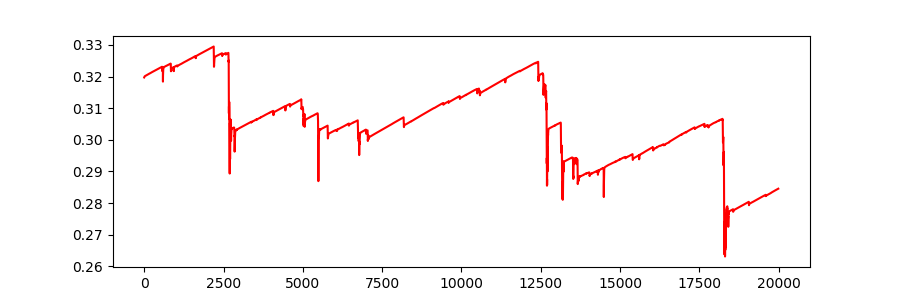

<IPython.core.display.Javascript object>


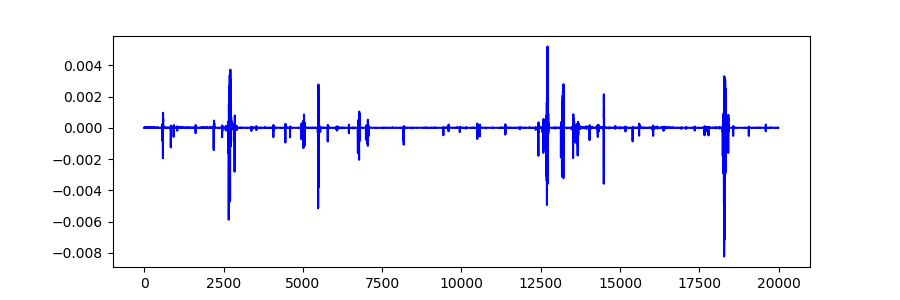

In [3]:
%matplotlib notebook

width = 9
height = width/5

plt.figure(1, figsize=(width,width/3))
plt.plot(data['S'], color = 'r')
plt.show()

plt.figure(2, figsize=(width,width/3))
plt.plot(data['dS/dt'], color = 'b')
plt.show()

### Distribution of $\frac{\partial S}{\partial t}$

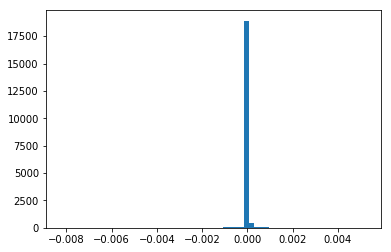

In [4]:
%matplotlib inline

plt.hist(data['dS/dt'], bins = 60)
plt.show()

#### Non-Normality of $\frac{\partial S}{\partial t}$

The following blocks demonstrate the non-normality of $\frac{\partial S}{\partial t}$ both with the Kolmogorov-Smirnov test and a visual comparison. The visual comparison also indicates that we should define events more tightly "than normal" with respect to the standard deviation of the data. 

In [5]:
normalized_dsdt = (data['dS/dt'] - data['dS/dt'].mean())/data['dS/dt'].std()
stats.kstest(normalized_dsdt, 'norm')

KstestResult(statistic=0.4473921795072221, pvalue=0.0)

In [6]:
normal_data = np.random.normal(0,1,20000)
stats.kstest(normal_data, 'norm')

KstestResult(statistic=0.005440401902102487, pvalue=0.5946478989689394)

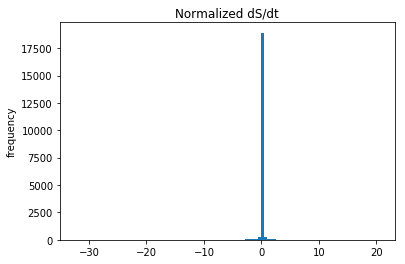

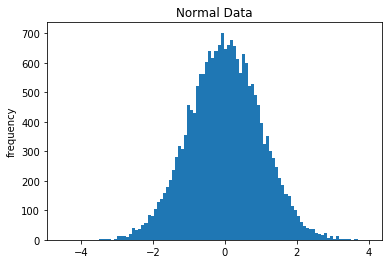

In [7]:
%matplotlib inline

plt.hist(normalized_dsdt, bins = 100)
plt.title('Normalized dS/dt')
plt.ylabel('frequency')
plt.show()

plt.hist(normal_data, bins = 100)
plt.title('Normal Data')
plt.ylabel('frequency')
plt.show()

## Data Processing

Event marking, data labeling and segmentation. 

In [8]:
# Event marker.

def event_marker(data, 
                 window_size = 4, 
                 enter_param = 1, 
                 leave_param = .5):
    std_dev = data['dS/dt'].std()
    mean = data['dS/dt'].mean()
    event_threshold = enter_param * std_dev
    leave_threshold = leave_param * std_dev
    
    # Mark Events with Ordinals
    event = np.zeros([len(data)], dtype = int)
    window = collections.deque(abs(data['dS/dt'][0 : window_size] - mean), window_size)
    event_mark = 0
    mark = False
    for i in range(len(data) - (window_size + 1)):
        if not mark and (min(window) > event_threshold):
            event_mark += 1
            mark = True
        elif mark and (max(window) < leave_threshold):
            mark = False
        if mark:
            event[i] = event_mark
        window.append(abs(data['dS/dt'][i + window_size + 1] - mean))
        data.loc[i, 'event'] = event_mark
    data['event'] = event
    
    # Record Event Magnitude
    event_mag = np.full([len(data)], np.nan)
    last_event = data['event'].max()
    for i in range(1, int(last_event) + 1):
        indices = data.loc[data['event'] == i].index.values
        values = data.loc[indices, 'S'].values
        magnitude = max(values) - min(values)
        event_mag[indices] = magnitude
    data['magnitude'] = event_mag
    
    # Time Since Last Event/Last Event Magnitude/Segment ID
    t_plus =np.full([len(data)], np.nan)
    last_mag = np.full([len(data)], np.nan)
    segment = np.full([len(data)], np.nan)
    magnitude = np.nan
    segment_id = 0
    time = False
    t = 1
    for i in range(1, len(data)):
        if time:
            t_plus[i] = t
            last_mag[i] = magnitude
            segment[i]= segment_id
            t += 1
        if data.loc[i, 'event'] > 0 and data.loc[i + 1, 'event'] == 0:
            time = True
            t = 1
            magnitude = data.loc[i, 'magnitude']
            segment_id += 1
        elif data.loc[i, 'event'] == 0 and data.loc[i + 1, 'event'] > 0:
            time = False
        if data.loc[i, 'event'] == last_event:
            break
    data['t+'] = t_plus
    data['last magnitude'] = last_mag
    data['segment'] = segment
    
    # Time Until Next Event/Magnitude of Next Event
    t_minus = np.full([len(data)], np.nan)
    next_mag = np.full([len(data)], np.nan)
    magnitude = np.nan
    time = False
    t = 1
    for i in range(len(data) - 1, 1, -1):
        if time:
            t_minus[i] = t
            next_mag[i] = magnitude
            t += 1
        if data.loc[i, 'event'] > 0 and data.loc[i - 1, 'event'] == 0:
            time = True
            t = 1
            magnitude = data.loc[i, 'magnitude']
        elif data.loc[i, 'event'] == 0 and data.loc[i - 1, 'event'] > 0:
            time = False
        if data.loc[i, 'event'] == 1:
            break
    data['t-'] = t_minus 
    data['next magnitude'] = next_mag 
    return data

data = event_marker(data)

In [9]:
data[599:2667]

,t,S,dS/dt,event,magnitude,t+,last magnitude,segment,t-,next magnitude
599,600,0.322146,0.000098,1,0.004349,NaN,NaN,NaN,NaN,NaN
600,601,0.322310,0.000164,0,NaN,1.0,0.004349,1.0,1591.0,0.006412
601,602,0.322323,0.000013,0,NaN,2.0,0.004349,1.0,1590.0,0.006412
602,603,0.322375,0.000052,0,NaN,3.0,0.004349,1.0,1589.0,0.006412
603,604,0.322495,0.000120,0,NaN,4.0,0.004349,1.0,1588.0,0.006412
604,605,0.322556,0.000061,0,NaN,5.0,0.004349,1.0,1587.0,0.006412
605,606,0.322590,0.000034,0,NaN,6.0,0.004349,1.0,1586.0,0.006412
606,607,0.322628,0.000039,0,NaN,7.0,0.004349,1.0,1585.0,0.006412
607,608,0.322685,0.000056,0,NaN,8.0,0.004349,1.0,1584.0,0.006412
608,609,0.322748,0.000063,0,NaN,9.0,0.004349,1.0,1583.0,0.006412


<IPython.core.display.Javascript object>


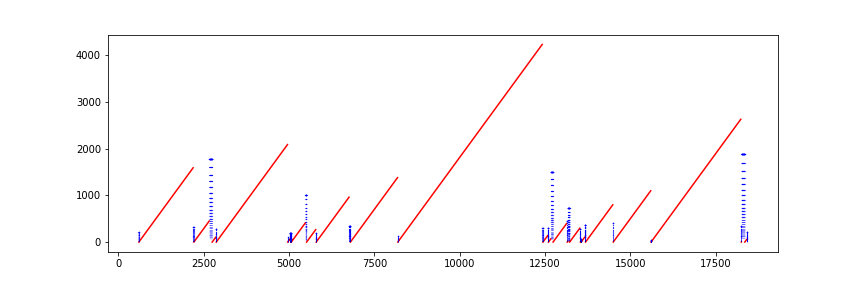

In [11]:
%matplotlib notebook
%matplotlib notebook

width = 12
mag_scale = 50000
plt.figure(figsize=(width,width/3))
plt.plot(data['t+'], color = 'r')
plt.plot(data['magnitude'] * mag_scale, '.', color = 'b', label = 'Scaled Magnitude', markersize = .3)
for i in range(1, 100):
    scale_factor = .9**i
    plt.plot(data['magnitude'] * mag_scale * scale_factor, '.', color = 'b', markersize = .1 * scale_factor)
plt.show()

<IPython.core.display.Javascript object>


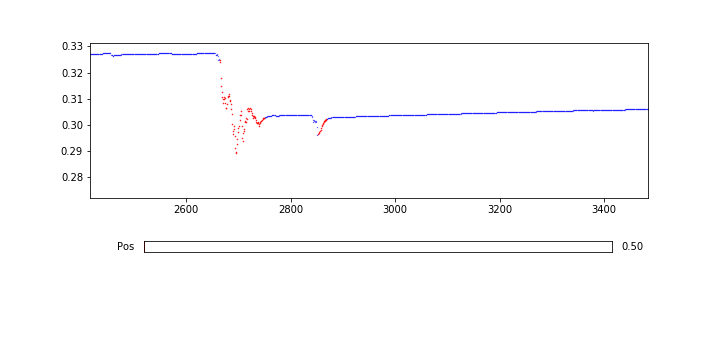

In [24]:
%matplotlib notebook

fig, ax = plt.subplots(figsize = (10,5))
plt.subplots_adjust(bottom=0.45)

non_event_data = data.loc[data['event'] == 0]
event_data = data.loc[data['event'] > 0]

plot_min = data['S'].min() - .01
plot_max = data['S'].max() + .01

nt = non_event_data['t']
nS = non_event_data['S']
et = event_data['t']
eS = event_data['S']

l1, = plt.plot(nt,nS, '.', color = 'b', markersize = .5)
l2, = plt.plot(et,eS, '.', color = 'r', markersize = 1)

plt.axis([0, 4000, plot_min, plot_max])

axpos = plt.axes([0.2, 0.3, 0.65, 0.03])

spos = Slider(axpos, 'Pos', 0, len(data))

def update(val):
    pos = spos.val
    ax.axis([pos,pos+5000, plot_min, plot_max])
    fig.canvas.draw_idle()

spos.on_changed(update)

plt.show()

In [14]:
def generate_code(length = 4):
    letters = string.ascii_lowercase
    return ''.join(random.choice(letters) for i in range(length))

def save_segments_to_disk(data, project_name):
    working_directory = os.getcwd()
    path = os.path.join(working_directory, project_name)
    path_str = str(path)
    if project_name not in os.listdir(os.getcwd()):
        try:
            os.mkdir(path)
        except:
            print("%s directory not created, save failed." % path_str)
            return None
    save_code = generate_code()
    print('Save code: ' + save_code)
    save_code += '_'
    saved_columns = ['t', 'S', 'dS/dt', 't+', 'last magnitude', 't-', 'next magnitude']
    num_segments = int(data['segment'].max())
    for i in range(num_segments):
        segment_name = save_code + str(i)
        segment_path = os.path.join(path, segment_name)
        segment = data.loc[data['segment'] == i + 1]
        save_segment = segment[saved_columns]
        save_segment.to_csv(segment_path, index = None, header=True)

save_segments_to_disk(data, 'Fault_Slip_Data')

Save code: hcfd


## Segment $\frac{\partial S}{\partial t}$ Visualization

Unique dS/dt values: 2164


<IPython.core.display.Javascript object>


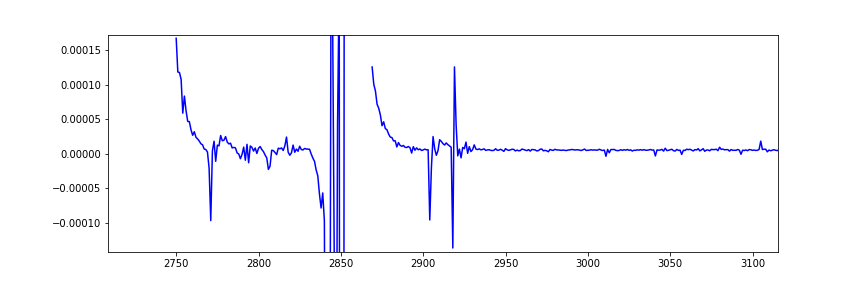

In [25]:
%matplotlib notebook

segment_data = data.loc[data['segment'] >= 1]

print("Unique dS/dt values: %d"%len(np.unique(segment_data['dS/dt'].values)))

if len(data) > len(segment_data):
    for i in range(int(segment_data['segment'].max())):
        segment = segment_data.loc[segment_data['segment'] == i + 1]
        plt.figure(2, figsize=(width,width/3))
        plt.plot(segment['t'], segment['dS/dt'], color = 'b')
    plt.show()

# Step2Vec

### Example Corpus Construction

In [16]:
project_name = 'Fault_Slip_Data'

def build_dictionary_and_corpus(project_name):
    dictionary = dict()
    corpus = [-1]
    project_path = os.path.join(os.getcwd(), project_name)
    segment_names = os.listdir(project_path)
    entry = 0
    for name in segment_names:
        segment = pd.read_csv(os.path.join(project_path, name))
        values = segment['dS/dt'].values
        for i in range(len(values)):
            value = values[i]
            if not value in dictionary.keys():
                dictionary[value] = entry
                entry += 1
        for i in range(len(values)):
            value = values[i]
            corpus.append(dictionary[value])
        corpus.append(-1)
    reverse_dictionary = dict(zip(dict(dictionary).values(), dict(dictionary).keys()))
    frequency_dictionary = collections.Counter(corpus)
    return corpus, dictionary, reverse_dictionary, frequency_dictionary

In [17]:
corpus, dictionary, reverse_dictionary, frequency_dictionary = build_dictionary_and_corpus(project_name)
for i in range(100):
    print(corpus[2000 + i], end = ' ')

29 117 93 42 42 194 80 114 31 58 105 77 87 102 42 160 18 42 82 50 117 108 111 42 80 94 222 117 53 108 77 42 42 91 108 337 338 339 340 341 342 343 344 345 -1 346 189 253 261 164 347 348 349 350 351 352 353 354 355 316 10 356 357 358 320 299 258 259 54 192 49 104 255 102 94 103 31 155 104 58 111 31 44 55 87 122 83 91 82 84 99 31 117 91 47 29 155 36 85 222 

In [18]:
print('%d unique values recorded.'%len(dictionary), end = '\n\n')
for i in range(10):
    print('Key: '+str(list(dictionary.keys())[i]), end = ', ')
    print('Value: '+str(list(dictionary.values())[i]))

2164 unique values recorded.

Key: 0.00016425, Value: 0
Key: 1.25e-05, Value: 1
Key: 5.24e-05, Value: 2
Key: 0.00012025, Value: 3
Key: 6.07e-05, Value: 4
Key: 3.3600000000000004e-05, Value: 5
Key: 3.87e-05, Value: 6
Key: 5.65e-05, Value: 7
Key: 6.29e-05, Value: 8
Key: 3.59e-05, Value: 9


### Example Batch Generator

In [19]:
data_index = 0
left_right_index = [0,0]
subsample_indices = []

def subsample_keep_probability(frequency_ratio, parameter = 0.01):
    return min(1, (math.sqrt(frequency_ratio/parameter)+1)*parameter/frequency_ratio)

def generate_embedding_batch(corpus, 
                             batch_size = None, 
                             n_left = 2, 
                             n_right = 2, 
                             subsample = True, 
                             subsample_parameter = 0.01):
    global data_index
    global left_right_index
    global subsample_indices
    corpus_size = len(corpus)
    assert isinstance(batch_size, int), "Batch Generator: You must specify a batch size."
    batch = np.ndarray(shape=(batch_size), dtype = np.int32)
    labels = np.ndarray(shape=(batch_size,1), dtype = np.int32)
    record_position = 0
    corpus_size = len(corpus)
    while record_position < batch_size:
        if subsample and corpus[data_index] in subsample_indices:
            data_index = (data_index + 1) % corpus_size
            continue
        
        if corpus[data_index] == -1:
            data_index = (data_index + 1) % corpus_size
            continue
            
        for i in range(left_right_index[0], n_left):
            if record_position == batch_size:
                break
            if corpus[data_index - 1 - i] == -1:
                break
            if subsample == True and corpus[data_index-1-i] in subsample_indices:
                continue
            else:
                batch[record_position] = corpus[data_index]
                labels[record_position] = corpus[data_index - 1 - i]
                left_right_index[0] += 1
                record_position += 1
                
        for i in range(left_right_index[1], n_right):
            if record_position == batch_size:
                break
            if corpus[data_index + 1 + i] == -1:
                break
            if subsample and corpus[data_index+1+i] in subsample_indices:
                continue
            else:
                batch[record_position] = corpus[data_index]
                labels[record_position] = corpus[data_index + 1 + i]
                left_right_index[1] += 1
                record_position += 1
                 
        if record_position == batch_size:
            break

        if subsample:
            frequency_ratio = frequency_dictionary[corpus[data_index]]/corpus_size 
            probability = subsample_keep_probability(frequency_ratio, parameter = subsample_parameter)
            sample = random.uniform(0,1)
            if sample > probability:
                subsample_indices.append(corpus[data_index])
        data_index = (data_index + 1) % corpus_size
        word_recorded = False
        left_right_index = [0,0]
    return batch, labels

In [20]:
data_index = 0
example_batch, example_labels = generate_embedding_batch(corpus, batch_size = 12)
print("Example Text:")
for i in range(1,10):
    print(reverse_dictionary[corpus[i]], end = " ")
print(" ")
print("Example Numerical Pairs:")
print(example_batch)
print(example_labels)

Example Text:
0.00016425 1.25e-05 5.24e-05 0.00012025 6.07e-05 3.3600000000000004e-05 3.87e-05 5.65e-05 6.29e-05  
Example Numerical Pairs:
[0 0 1 1 1 2 2 2 2 3 3 3]
[[1]
 [2]
 [0]
 [2]
 [3]
 [1]
 [0]
 [3]
 [4]
 [2]
 [1]
 [4]]


### Example Embedding Graph

In [21]:
embedding_size = len(dictionary)
embedding_dimension = 64
number_negative_samples = 64
batch_size = 128

Step2VecSG_graph = tf.Graph()

with Step2VecSG_graph.as_default():
    # Input: Integer indices of rows to look up. 
    train_data = tf.placeholder(tf.int32, shape = [batch_size])
    train_labels = tf.placeholder(tf.int32, shape = [batch_size, 1])
    
    # Variables
    embeddings = tf.Variable(tf.random_uniform([embedding_size, embedding_dimension],
                                               minval = -1.0,
                                               maxval = 1.0))
    softmax_weights = tf.Variable(tf.truncated_normal([embedding_size, embedding_dimension],
                                                      stddev = 1.0/math.sqrt(embedding_dimension)))
    softmax_biases = tf.Variable(tf.zeros([embedding_size]))
    
    # Model.
    embed = tf.nn.embedding_lookup(embeddings, train_data)
    sampled_softmax_loss = tf.nn.sampled_softmax_loss(weights=softmax_weights, 
                               biases = softmax_biases, 
                               inputs = embed,
                               labels = train_labels, 
                               num_sampled = number_negative_samples, 
                               num_classes = embedding_size)
    
    loss = tf.reduce_mean(sampled_softmax_loss)
    
    # Optimizer.
    optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
    
    # Normalized embeddings.
    embedding_norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keepdims=True))
    normalized_embeddings = embeddings/embedding_norm

Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.


In [22]:
training_time = 20 # minutes
report_frequency = 30000 # by iteration

# Clear subsampled indices before each from-scratch training session. 
subsample_indices = []

# Start with no subsampling. 
subsample_trigger = False
subsample_param = .1

with tf.Session(graph = Step2VecSG_graph) as session:
    start_time = time.time()
    run_time = 0
    tf.global_variables_initializer().run()
    print('Variables Initialized')
    average_loss = 0
    iteration = 0
    checkpoint = [5., 10., 15., 20., 25., 30., 35.]
    checkpoint_index = 0
    while run_time < training_time*60:
        batch_data, batch_labels = generate_embedding_batch(corpus,
                                                             batch_size = batch_size, 
                                                             subsample = subsample_trigger,
                                                             subsample_parameter = subsample_param)
        feed_dict = {train_data : batch_data, train_labels : batch_labels}
        _, l = session.run([optimizer, loss], feed_dict=feed_dict)
        run_time = time.time() - start_time
        average_loss += l
        if iteration % report_frequency == 0 and iteration > 0:
            average_loss = average_loss / report_frequency
            print('Average loss at iteration %d: %f' % (iteration, average_loss))
            print('Number of subsampled indices: %d' % len(subsample_indices))
            average_loss = 0
        iteration += 1
        run_time_min = run_time/60
        if run_time_min > checkpoint[checkpoint_index]:
            print("Run time: %f minutes." % run_time_min)
            subsample_trigger = True
            subsample_param = subsample_param*.1
            print("Subsample Parameter: %f." % subsample_param)
            checkpoint_index += 1
    Step2Vec_embeddings = normalized_embeddings.eval()
    print('Embedding complete.')

Variables Initialized
Average loss at iteration 30000: 1.987701
Number of subsampled indices: 0
Average loss at iteration 60000: 1.710650
Number of subsampled indices: 0
Average loss at iteration 90000: 1.663589
Number of subsampled indices: 0
Average loss at iteration 120000: 1.638245
Number of subsampled indices: 0
Average loss at iteration 150000: 1.624370
Number of subsampled indices: 0
Average loss at iteration 180000: 1.612515
Number of subsampled indices: 0
Average loss at iteration 210000: 1.599589
Number of subsampled indices: 0
Run time: 5.000001 minutes.
Subsample Parameter: 0.010000.
Average loss at iteration 240000: 1.591792
Number of subsampled indices: 0
Average loss at iteration 270000: 1.586028
Number of subsampled indices: 0
Average loss at iteration 300000: 1.579836
Number of subsampled indices: 0
Average loss at iteration 330000: 1.572983
Number of subsampled indices: 0
Average loss at iteration 360000: 1.569373
Number of subsampled indices: 0
Average loss at iterat

In [23]:
Step2Vec_embeddings[0]

array([-0.05672921, -0.13524453, -0.13661559, -0.00454746,  0.05236039,
        0.13960773,  0.1551208 , -0.08888342,  0.09622437, -0.18789484,
        0.04627733, -0.01650277,  0.07130639,  0.04703951, -0.02836622,
       -0.07337619, -0.05612396, -0.20227621,  0.16421068, -0.03461532,
       -0.10449227, -0.04286376,  0.1146256 , -0.09636831,  0.08197579,
        0.23452899, -0.09401217,  0.06935691, -0.32460657, -0.2314581 ,
        0.23548412,  0.14953704, -0.16815068, -0.02812705, -0.09667491,
        0.1723173 , -0.12964764, -0.11604888,  0.14285052, -0.00140803,
       -0.04800553,  0.10164414, -0.04870503,  0.03649042,  0.15077701,
       -0.12972474, -0.03343612, -0.04365735, -0.1602094 , -0.09840295,
        0.13212958,  0.01814959, -0.0288941 , -0.18613988, -0.05758147,
        0.09321427, -0.09509428,  0.15805247,  0.0751209 , -0.06291903,
        0.2899215 , -0.06716039, -0.03262412, -0.11837722], dtype=float32)